In [1]:
%load_ext rpy2.ipython

from src.pipeline import Comprehensive_Scan

import os
import pandas as pd
import numpy as np
from multiprocessing import Pool , Manager

# Distribututions of Restriction Modification Systems in Prokaryotic Genomes

In this notebook, we generate alignments to curated database of restriction modificaiton (RM) systems composed of protein sequences and protein profile HHMs (Please refer to the RMdatabaseconstruction notebook to see evidence and justification for the database). Once alignments are generated, iterate through results for every prokarytoic organism searched to annotated RM systems. We also attempt to provide evidence regarding possible Type IIG RM systems, showing that representatives of clusters generate Profile-Profile alignments to Type IIG entries in PDB.

## Table of Contents
#### I. [RM searches of RefSeq Genomes](#rmsearch)
#### II.[Annotation of new TypeIIG proteins](#pTIIG)


<a id='rmsearch'></a>

# I. RM searches of RefSeq Genomes
In this step, we are searching over 139,000 genomes in Refseq using both BLASTp and HMMER. 

In [9]:
db_location='/media/zinserlab/4TbWesterDigital/Databases/RM/'
gb_dir='/media/zinserlab/4TbWesterDigital/Prokaryotes/'
probelibrary= db_location+'non-putative_rebase.fasta'
HMM_searchspace= db_location+'RMwithFalsepos.hmm'
BLASTexceptions= db_location+'BLASTexceptions.fasta'
falsepos=db_location+'Falsepos_HMMs.txt'
resultsdir= 'data/search_results/'


In [6]:
if False:
    gb_dir='data/gbtest/'
    resultsdir='data/search_test/'

#when probe library is blast exceptions, 10x faster
Comprehensive_Scan(target_dir=gb_dir,results_dir=resultsdir,probelibrary=BLASTexceptions,
               HMM=HMM_searchspace,BLASTexsee ceptions=BLASTexceptions,threads=4,FalsePositiveHMMs=falsepos,TenativePositiveHMMs_list=['ResIII'])


Running Post Processing script
We are now iterating through our search results to collect RM counts for each assembly. RM classification codes are as follows:  

| code  |  description |  Primary domains |
|---|---|---|
|  mT1 |  Type 1 Methyltransferase subunit|  HsdM_N, N6_Mtase |
|  rT1 |  Type 1 Endonuclease subunit|  EcoEI_R_C,EcoR124_C,HSDR_N,HSDR_N_2,ResIII |
|  rmT1 |  Full Type 1 RM systems |   |
|  mT2 |  Type 2 Methyltransferase | DNA_methylase, MethyltransfD12, N6_Mtase, N6_N4_Mtase, many more check SI |
|  rT2 |  Type 2 Endonuclease |  Too many to list, check SI |
|  rmT3 |  Full Type 2 RM systems |   |
|  mT3 |  Type 3 Methyltransferase subunit| N6_N4_Mtase, TypeIII_RM_meth |
|  rT3 |  Type 3 Endonuclease |  ResIII |
|  rmT3 |  Full Type 3 RM systems |   |
|  T4 |  Methyl Degrading Endonucleases |  Mrr_cat, Mrr_N |
|  T2G |  Type IIG RM systems | Too many to list, check SI  |
|  pT2G |  possible Type IIG RM systems | single methyltransferase domain |
|  rmT? |  Ambiguous Classification |   |

In [12]:
%run src/RM_postprocessing.py

/home/zinserlab/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:793: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  exit_ignore=exit_ignore)


<a id='pTIIG'></a>

# II. Processing pTIIG proteins
In our postprocessing script, we find that there is a multitude of of proteins that have a DNA methyltransferase domain and are >750 amino acids. We belive that these proteins are likly TypeIIG RM systems that do not have a defined domain. In order to tackel this problem, we will perform the following

1. Cluster using psi-cd-hit
    a. 85% alignment length between query and sequence, minimum 35% identity
2. Query cluster representative for HHpred search
3. Annotate cluster according to the alignment of the cluster representative
4. Alter TypeIIG RM counts to reflect proteins that we have annotated as TypeIIG


In [ ]:
%%bash
./src/cdhit/psi-cd-hit/psi-cd-hit.pl -i data/pTIIG/pTIIG.fasta -o data/pTIIG/pTIIG_CdHit -c 0.35 -aL .85 -aS .85 -g 1

In [25]:
def parse_clstr(file):
    m=[]
    with open(file,'r') as f:
        for line in f:
            if line[0] == '>':
                cluster = int(line.strip().split(' ')[-1])
            else:
                dat = line.split(', >')[-1]
                accession,dat = dat.split('...')
                if '*' in dat:
                    m.append([accession,cluster,True,np.nan])
                else:
                    pcnt = dat.split('/')[-1] #isolating percent identity to reference
                    pcnt = float(pcnt.replace('%',''))#removing %
                    m.append([accession,cluster,False,pcnt])
    df = pd.DataFrame(m)
    df.columns = ['accession','cluster','is_reference','identity_to_ref']
    return(df)
clusters = parse_clstr('data/pTIIG/pTIIG_CdHit.clstr')
refs=Fasta()
pTIIG=Fasta('data/pTIIG/pTIIG.fasta')
for accession in clusters[clusters['is_reference']]['accession']:
    refs[pTIIG.get_header(accession)] = pTIIG[accession]
refs.write_file('data/pTIIG/pTIIG_hhpredin.fasta')

In [29]:
import tempfile,subprocess,shutil
#Launching HHpred
hhblits_arg=['hhblits', '-cpu', '4', '-d', '/media/zinserlab/500GBInternal/databases/uniprot20_2016_02/uniprot20_2016_02',
             '-n', '3','-mact', '.35']
hhsearch_args=['hhsearch','-cpu', '4', '-i', 'query.a3m', '-d', 
               '/media/zinserlab/500GBInternal/databases/pdb/pdb70',  
               '-p', '20', '-Z', '250', '-loc', '-z', '1', '-b',
               '1', '-B', '250', '-ssm', '2', '-sc', '1', '-seq',
               '1', '-norealign', '-maxres', '32000', '-contxt',
               '/media/zinserlab/500GBInternal/hh-suite/data/context_data.crf']
             
queries = Fasta('data/pTIIG/pTIIG_hhpredin.fasta')
results = 'data/pTIIG/hhpred_results'
computed=set([f.split('.')[0] for f in os.listdir(results)])
itot=len(queries)
for i,el in enumerate(queries):
    pcnt = str(round((i+1)/itot*100,3))
    print("Progress: {}%    Processing: {}".format(pcnt,el),end='\r')
    if el not in computed:
        query = el.split()[0][1:]#isolate only the accession
        #creating temporary directory and file locations
        tempdir = tempfile.mkdtemp(suffix='_hhpred')         
        query_fasta = os.path.join(tempdir,query+'.fasta')
        query_hhblits = os.path.join(results,query+'.hhblits.hhr')
        query_a3m = os.path.join(tempdir,query+'.a3m')
        query_hhsearch = os.path.join(results,query+'.hhsearch.hhr')                 
        #create fasta file
        tempfasta = Fasta()
        tempfasta[el] = queries[el]         
        tempfasta.write_file(query_fasta)
        hhblits_arg.extend(['-i',query_fasta,'-o',query_hhblits,'-oa3m',query_a3m])
        hhsearch_args.extend(['-i',query_a3m,'-o',query_hhsearch])
        subprocess.call(hhblits_arg)
        subprocess.call(hhsearch_args)
        #remove temp files
        shutil.rmtree(tempdir)

In [34]:
#Compilling results into one matrix

def process_hhblitsresults(file):
    f = open(file,'r')
    query,assembly = f.readline().strip().split()[-2:]
    m = []
    reading = False
    for line in f:
        if reading:
            temp=line.strip().split()
            if not temp:
                f.close()
                return(m)
            dat = temp[-9:]
            if '-' in dat[-1] and '(' in dat[-1]:
                fix=dat.pop()
                fix=fix.split('(')
                fix[-1]='('+fix[-1]
                dat.extend(fix)
                dat.pop(0)
            dat[0:5] = [float(el) for el in dat[0:5]]                        
            prot = [assembly,query,int(temp[0]),temp[1],'_'.join(temp[2:-9])]
            prot.extend(dat)
            m.append(prot)
        elif ' No Hit' in line:
            reading = True
            
resultspath = 'data/pTIIG/hhpred_results/'
files = os.listdir(resultspath)
results=[]
for file in files:
    if '.hhsearch.hhr' in file:
        results.extend(process_hhblitsresults(resultspath+file))
hhblits_df = pd.DataFrame(results)
hhblits_df.columns = ['assembly','query','No','Hit','definition','Prob','E-value','P-value','Score','SS','Cols','QueryHMM','Template','HMM']
#restricting to probs >= 99.5
hhblits_df= hhblits_df[hhblits_df['Prob'] >= 99.5]
hhblits_df.to_csv('data/pTIIG/compiledhhpred_results.csv',index=False)
hhblits_df = hhblits_df.set_index('query')
hhblits_df

,assembly,query,No,Hit,definition,Prob,E-value,P-value,Score,SS,Cols,QueryHMM,Template,HMM
0,GCF_002265395,NZ_NOWC01000006|194225..197131,1,3QV2_A,5-cytosine_DNA_methyltr,100.0,2.800000e-33,4.700000e-38,314.8,0.0,301,1-463,9-327,(327)
1,GCF_002265395,NZ_NOWC01000006|194225..197131,2,1G55_A,DNA_CYTOSINE_METHYLTRAN,99.9,1.900000e-32,3.100000e-37,310.2,0.0,313,1-459,1-343,(343)
2,GCF_002265395,NZ_NOWC01000006|194225..197131,3,3LX6_A,Cytosine-specific_methy,99.9,2.200000e-32,3.700000e-37,316.8,0.0,329,1-469,25-402,(410)
3,GCF_002265395,NZ_NOWC01000006|194225..197131,4,1SKM_A,Modification_methylase,99.9,2.500000e-32,4.200000e-37,307.2,0.0,301,1-463,10-324,(327)
4,GCF_002265395,NZ_NOWC01000006|194225..197131,5,5CIY_A,Modification_methylase,99.9,2.500000e-32,4.200000e-37,307.2,0.0,301,1-463,10-324,(327)
5,GCF_002265395,NZ_NOWC01000006|194225..197131,6,6FDF_C,tRNA_(cytosine(38)-C(5),99.9,5.000000e-32,8.400000e-37,305.6,0.0,311,1-462,9-333,(334)
6,GCF_002265395,NZ_NOWC01000006|194225..197131,7,6FDF_A,tRNA_(cytosine(38)-C(5),99.9,5.000000e-32,8.400000e-37,305.6,0.0,311,1-462,9-333,(334)
7,GCF_002265395,NZ_NOWC01000006|194225..197131,8,3G7U_A,Cytosine-specific_methy,99.9,8.400000e-32,1.400000e-36,309.0,0.0,364,1-463,1-369,(376)
8,GCF_002265395,NZ_NOWC01000006|194225..197131,9,3UBT_Y,Modification_methylase,99.9,2.100000e-31,3.400000e-36,300.3,0.0,303,3-463,1-326,(331)
9,GCF_002265395,NZ_NOWC01000006|194225..197131,10,4DKJ_A,Cytosine-specific_methy,99.9,2.400000e-31,4.000000e-36,306.6,0.0,309,1-465,9-396,(403)


In [66]:
# We will now attempt to classify each protein by looking for alignments to specific strucutres
#note, by my definition, all pTIIG has a detectable MTase domain by HMMer
#We will first organize a spreadsheet for the data with the following columns
# prot: the pTIIG protein, assembly_origin: assembly protein came from, Blast_exception_hit: blast alignment to exception prots
# cluster: cluster number, rep: True/False if it is the representative of that cluster, 
#HHpred_best_hit: Best alignment from HHpred
#HHpred_hits: if rep is true, hits with >=99.5 prob, if rep is false, hit is inherited from representative

#setting up supporting data strcutres and functions for information retrevial 

pTIIG_fasta = Fasta('data/pTIIG/pTIIG.fasta')
pTIIG_representatives_fasta = Fasta('data/pTIIG/pTIIG_hhpredin.fasta')
pTIIG_representatives = set([header[1:].split()[0] for header in pTIIG_representatives_fasta])
clusters = parse_clstr('data/pTIIG/pTIIG_CdHit.clstr')

accession_cluster = {row[0]:row[1] for row in clusters.itertuples(index=False)}

cluster_representative = {}
for accession in pTIIG_representatives:
    cluster_representative[accession_cluster[accession]] = accession

#helper function to retrieve best blast
def get_best_blast(accession,assembly):
    df = pd.read_csv('data/search_results/'+assembly+'.bioscan.csv')
    df = df.set_index('accession')
    return(df.loc[accession][-1])
#helper function to return if this sequence is a representative
def is_rep(accession):
    if accession in pTIIG_representatives:
        return True
    else:
        return False

_m=[]
i=1
for header in pTIIG_fasta:
    print(str(i)+'/'+str(len(pTIIG_fasta)), end='\r')
    query, assembly= header[1:].split()
    dat = [query,assembly,get_best_blast(query,assembly),accession_cluster[query],is_rep(query)]
    _m.append(dat)
    i+=1
pTIIG_df = pd.DataFrame(_m)
pTIIG_df.columns = ['query','assembly','best_blast','cluster','is_rep']
pTIIG_df = pTIIG_df.set_index('query')

In [72]:
pTIIG_df

,assembly,best_blast,cluster,is_rep,blits_hits
query,,,,,
NZ_QADT01000001|complement(114372..117134),GCF_003187345,Lmo11238I;0.0;969.0,940,False,5HR4
NZ_NXHN01000051|31399..34362,GCF_002411785,NaN,846,False,5HR4
NZ_NXHO01000013|106034..108997,GCF_002411815,NaN,846,False,5HR4
NZ_NXHP01000059|31354..34317,GCF_002411845,NaN,846,False,5HR4
NZ_CP031449|complement(3214433..3217396),GCF_002411865,NaN,846,False,5HR4
NZ_NXHU01000023|9540..13154,GCF_002411925,Vtu19109I;0.0;1042.0,373,False,5HR4
NZ_BEZH01000017|24815..27907,GCF_003215005,BbuB31II;4.1099999999999984e-172;529.0,744,True,4XQK
NZ_BEZH01000136|61533..65144,GCF_003215005,ScoDS2II_(ScoDS2IIA);2.2399999999999993e-107;3...,171,False,5HR4
NZ_BEZH01000132|complement(53760..56858),GCF_003215005,NaN,532,False,4ZCF


In [69]:
#Adding hhblits data

from src.pipeline import alignment_conflict

#Note that we are removing redundant alignments by picking the best one
def remove_conflicts(df):
    i = 0
    while i+1 < len(df):
        if type(df) == pd.core.series.Series:
            return (df)
        se1 = df.iloc[i].QueryHMM.split('-')
        se1 = tuple([int(se1[0]),int(se1[1])])
        conflicts = [True]*(i+1)
        for i2 in range(i+1,len(df)):
            se2=tuple(df.iloc[i2].QueryHMM.split('-'))
            se2 = tuple([int(se2[0]),int(se2[1])])
            conflicts.append(not alignment_conflict(se1,se2,threshold = .5))
        df = df[conflicts]
        i = i+1
    return (df)


def get_all_blits(query):
    df = hhblits_df.loc[query]
    df = remove_conflicts(df)
    out = set([el.split('_')[0] for el in df['Hit']])
    return(';'.join(out))

besthits=[]
allhits=[]
missing = []
i=1

for row in pTIIG_df.itertuples():
    if not row[-1]:
        rep = cluster_representative[int(row[3])]
    else:
        rep = row[0]
    try:
        allhit=get_all_blits(rep)
        
    except KeyError:
        allhit=''
        missing.append(list(row))
    allhits.append(allhit)
    i+=1
pTIIG_df['blits_hits'] = allhits

In [71]:
pTIIG_df

,assembly,best_blast,cluster,is_rep,blits_hits
query,,,,,
NZ_QADT01000001|complement(114372..117134),GCF_003187345,Lmo11238I;0.0;969.0,940,False,5HR4
NZ_NXHN01000051|31399..34362,GCF_002411785,NaN,846,False,5HR4
NZ_NXHO01000013|106034..108997,GCF_002411815,NaN,846,False,5HR4
NZ_NXHP01000059|31354..34317,GCF_002411845,NaN,846,False,5HR4
NZ_CP031449|complement(3214433..3217396),GCF_002411865,NaN,846,False,5HR4
NZ_NXHU01000023|9540..13154,GCF_002411925,Vtu19109I;0.0;1042.0,373,False,5HR4
NZ_BEZH01000017|24815..27907,GCF_003215005,BbuB31II;4.1099999999999984e-172;529.0,744,True,4XQK
NZ_BEZH01000136|61533..65144,GCF_003215005,ScoDS2II_(ScoDS2IIA);2.2399999999999993e-107;3...,171,False,5HR4
NZ_BEZH01000132|complement(53760..56858),GCF_003215005,NaN,532,False,4ZCF


### Accepted PDB IDs in bold
1BCO = BACTERIOPHAGE MU TRANSPOSASE CORE DOMAIN<br>
1DQ3 = CRYSTAL STRUCTURE OF AN ARCHAEAL INTEIN-ENCODED HOMING ENDONUCLEASE PI-PFUI<br>
1G55 = Structure of human DNMT2, an enigmatic DNA methyltransferase homologue<br>
1G60 = Crystal Structure of Methyltransferase MboIIa<br>
1NW8 = Structure of L72P mutant beta class N6-adenine DNA methyltransferase RsrI<br>
1SKM = HhaI methyltransferase in complex with DNA containing an abasic south carbocyclic sugar at its target site<br>
2AR0 = Crystal structure of Type I restriction enzyme EcoKI M protein (EC 2.1.1.72) (M.EcoKI)<br>
2AU3 = Crystal Structure of the Aquifex aeolicus primase (Zinc Binding and RNA Polymerase Domains)<br>
2DPM = DPNM DNA ADENINE METHYLTRANSFERASE FROM STREPTOCCOCUS PNEUMONIAE COMPLEXED WITH S-ADENOSYLMETHIONINE<br>
2GTI = E. coli heptosyltransferase WaaC.<br>
2IH2 = adenine-specific DNA methyltransferase M.TaqI complexed with the cofactor <br>
2O8B = MutSalpha for mismatch repair<br>
2O8E = mismatch repair<br>
2OFI = DNA damage recognition and repair, DNA glycosylate I<br>
2Y7H = DNA bount Mehtylase complex Type I RM EcoKI<br>
3G7U = DNA modificaiton methyltransferase encoded with prophage<br>
3KHK = Crystal structure of type-I restriction-modification system methylation subunit from Methanosarchina mazei<br>
3LKD =Crystal Structure of the type I restriction-modification system methyltransferase subunit from Strep<br>
3QV2 = Structure Analysis of Entamoeba histolytica methyltransferase EhMeth<br>
**3S1S =  type IIG restriction endonuclease BpuSI**<br>
3SWR = Structure of human DNMT1<br>
3UBT = C71S Mutant of DNA Cytosine-5 Methyltransferase M.HaeIII Bound to DNA<br>
3UFB = modification subunit of a putative type I restriction enzyme from Vibrio vulnificus<br>
3V97 = bifunctional methyltransferase YcbY (RlmLK) from Escherichia coli, SAH binding<br>
4FT4 = Zea mays ZMET2 in complex H3(1-32)K9me2 peptide and SAH<br>
4H0N = DNMT2 mutatnt<br>
4L0J = translocation signal domain mediating conjugative transfer by type IV secretion systems<br>
4MYC = mitochondrial ABC transporter<br>
4MX7 = dGTP-dependent activation of tetrameric SAMHD1 deoxynucleoside triphosphate triphosphohydrolase (HIV restriction)<br>
**4PXG = TypeII restriction Enzyme Sau3AI (Type II REase)**<br>
4R3Z =  human ArgRS-GlnRS-AIMP1 complex<br>
4TSH = Streptococcus mutans adhesin P1<br>
**4XQK = Type ISP restriction-modification enzyme LlaBIII bound to DNA**<br>
**4ZCF = EcoP15I (Type III RM, with both R and M complexed together)**<br>
5CIY = histone H3K36me3 nucleosome by human de novo DNA methyltransferases<br>
5DO7 = Human Sterol Transporter ABCG5/ABCG8<br>
**5FFJ = Type ISP restriction-modification enzyme LlaGI** <br>
5HFJ =  M1.HpyAVI-SAM complex (type II M)<br>
**5HR4 = Type IIL restriction-modification enzyme MmeI** <br>
5IL1 = SAM-bound METTL3-METTL14 complex (RNA binding<br>
5IL2 =  SAH-bound METTL3-METTL14 complex<br>
5K7W = catalytic domain Mettl3/Mettl14 complex with SAH<br>
5X0Y = Snf2-Nucleosome complex with Snf2 bound to SHL2 of the nucleosome<br>
5YBB = structure of a type I MTase complex (2M+1S) bound to DNA and cofactor S-adenosyl methionine<br>
6FML = INO80core Nucleosome complex<br>


In [84]:
accepted_blits = set(['3S1S','4PXG','4XQK','4ZCF','5FFJ','5HR4'])
keep = []
for row in pTIIG_df.itertuples():
    blits_hits = set(row[-1].split(';'))
    if blits_hits.intersection(accepted_blits):
        keep.append(True)
    else:
        keep.append(False)
pTIIG_alnevidence = pTIIG_df[keep]
print("out of {t}, only {d} sequence do not have evidence of being TIIG RM systems".format(
    t=str(len(pTIIG_df)),d=str(len(pTIIG_df) - len(pTIIG_alnevidence))))

out of 33633, only 6486 sequence do not have evidence of being TIIG RM systems


In [100]:
pTIIG_alnevidence.to_csv('data/pTIIG/pTIIG_alignment_evidence.csv')
pTIIG_alnevidence

,query,assembly,best_blast,cluster,is_rep,blits_hits
0,NZ_QADT01000001|complement(114372..117134),GCF_003187345,Lmo11238I;0.0;969.0,940,False,5HR4
1,NZ_NXHN01000051|31399..34362,GCF_002411785,NaN,846,False,5HR4
2,NZ_NXHO01000013|106034..108997,GCF_002411815,NaN,846,False,5HR4
3,NZ_NXHP01000059|31354..34317,GCF_002411845,NaN,846,False,5HR4
4,NZ_CP031449|complement(3214433..3217396),GCF_002411865,NaN,846,False,5HR4
5,NZ_NXHU01000023|9540..13154,GCF_002411925,Vtu19109I;0.0;1042.0,373,False,5HR4
6,NZ_BEZH01000017|24815..27907,GCF_003215005,BbuB31II;4.1099999999999984e-172;529.0,744,True,4XQK
7,NZ_BEZH01000136|61533..65144,GCF_003215005,ScoDS2II_(ScoDS2IIA);2.2399999999999993e-107;3...,171,False,5HR4
8,NZ_BEZH01000132|complement(53760..56858),GCF_003215005,NaN,532,False,4ZCF
9,NZ_BEZI01000006|24660..28271,GCF_003215135,ScoDS2II_(ScoDS2IIA);2.2899999999999993e-107;3...,171,False,5HR4


# HHpred and blast alignments provide evidence for alignments 
We have found, out of 33633 first flagged, 27147 proteins have alignments to PDB entries with endonuclease activity. We will now load RMdat and do a posthoc correction, where we will subtract the the total number of entries of a particular assembly id from the pTIIG value in RMdat and add it to TIIG

In [4]:
pTIIG_alnevidence = pd.read_csv('data/pTIIG/pTIIG_alignment_evidence.csv')
assembly_TIIGchange = {}
#mapping assembly to change needed
print('Mapping pTIIG data....',end='\r')
for assembly in pTIIG_alnevidence['assembly']:
    if assembly not in assembly_TIIGchange:
        assembly_TIIGchange[assembly]=0
    assembly_TIIGchange[assembly]+=1 
print('Mapping pTIIG data....    [DONE]')
RMdat = pd.read_csv('data/RMdat.csv')

# doing our post-hoc correction of T2G RM
print('Doing post-hoc count correction for TIIG....',end='\r')
change=[]
pTIIG_posthoc=[]
for assembly in RMdat['orgid']:
    try:
        num = assembly_TIIGchange[assembly]
    except KeyError:
        num=0
    pTIIG_posthoc.append(num)
    
RMdat['T2G_posthoc'] = pTIIG_posthoc

RMdat['rmTotal'] = RMdat['rmT1'] + RMdat['rmT2'] + RMdat['rmT3'] + RMdat['T4'] + RMdat['T2G'] + RMdat['rmT?'] + RMdat['T2G_posthoc']
RMdat=RMdat.rename(index=str, columns={"GenomeSize(bp)": "bp"})
RMdat.to_csv('data/orgdat.csv',index=False)
print('Doing post-hoc count correction for TIIG....    [DONE]')

#Aggregation by genus
orgdat = pd.read_csv('data/orgdat.csv')
genus_phyla = {row[1]:row[2] for row in RMdat.itertuples(index=False)}

columns=list(orgdat.columns)[3:]
genera = set(orgdat['genus'])
m=[]
for genus in genera:
    gendat = orgdat[orgdat['genus'] == genus]
    means=gendat.mean()
    stds = gendat.std()
    newline_means =[means[column] for column in columns]
    newline_stds =[stds[column] for column in columns]
    if type(genus) == str:
        m.append([genus,genus_phyla[genus],len(gendat)]+newline_means+newline_stds)
        
generadat = pd.DataFrame(m)
generadat.columns = ['genus','phyla','num_isolates']+columns+[el+'_std' for el in columns]
generadat = generadat[pd.notnull(generadat['genus'])]
generadat.fillna(0,inplace=True)
generadat.to_csv('data/generadat.csv')
generadat        

Mapping pTIIG data....    [DONE]
Doing post-hoc count correction for TIIG....    [DONE]


,genus,phyla,num_isolates,bp,NumContigs,mT1,rT1,sT1,rmT1,mT2,...,rT3_std,rmT3_std,T4_std,T2G_std,pr_std,prm_std,rmT?_std,pT2G_std,T2G_posthoc_std,rmTotal_std
0,Fastidiosibacter,Proteobacteria,1,2.068591e+06,62.000000,2.000000,2.000000,2.000000,0.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,Sulfolobus,Crenarchaeota,75,2.335592e+06,10.493333,0.040000,0.040000,0.040000,0.026667,3.373333,...,0.310768,0.000000,0.115470,0.000000,0.0,0.0,0.000000,0.115470,0.115470,0.402694
2,Agrococcus,Actinobacteria,8,2.925572e+06,15.500000,0.750000,0.875000,0.750000,0.125000,2.000000,...,0.353553,0.000000,0.534522,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.534522
3,Prochlorothrix,Cyanobacteria,1,5.646343e+06,13.000000,7.000000,6.000000,8.000000,1.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,Scardovia,Actinobacteria,4,1.677048e+06,3.250000,0.500000,0.500000,1.000000,0.000000,2.000000,...,0.000000,0.000000,0.577350,0.577350,0.0,0.0,0.000000,0.000000,0.000000,1.732051
5,Sulfuritalea,Proteobacteria,1,3.802648e+06,1.000000,2.000000,1.000000,1.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
6,Desulfocapsa,Proteobacteria,1,4.023512e+06,2.000000,0.000000,2.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
7,Pelagibacterium,Proteobacteria,5,3.739766e+06,42.400000,0.400000,0.600000,0.400000,0.000000,2.200000,...,0.447214,0.000000,0.000000,0.447214,0.0,0.0,0.000000,0.000000,0.000000,0.547723
8,Geminocystis,Cyanobacteria,3,4.243852e+06,6.333333,2.333333,4.666667,5.000000,1.000000,14.666667,...,0.000000,0.000000,0.577350,0.000000,0.0,0.0,0.000000,5.507571,4.358899,7.211103
9,Cyanosarcina,Cyanobacteria,1,7.549128e+06,256.000000,1.000000,1.000000,1.000000,0.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000


In [8]:
#the following are collected from Shih et al 2013. PNAS
genus_morphology={'Trichodesmium':'Filamentous',
                 'Lyngbya':'Filamentous',
                  'Oscillatoria':'Filamentous',
                  'Microcoleus':'Filamentous',
                  'Fischerella':'Ramified',
                  'Mastigocladopsis':'Ramified',
                  'Calothrix':'Heterocystous',
                  'Nostoc':'Heterocystous',
                  'Anabaena':'Heterocystous',
                  'Cylindrospermum':'Heterocystous',
                  'Raphidiopsis':'Heterocystous',
                  'Cylindrospermopsis':'Heterocystous',
                  'Nodularia':'Heterocystous',
                  'Microchaete':'Heterocystous',
                  'Tolypothrix':'Heterocystous',
                  'Rivularia':'Heterocystous',
                  'Synechocystis':'Unicellular',
                  'Gloeocapsa':'Unicellular',
                  'Chroococcidiopsis':'Baeocystous',
                  'Dactylococcopsis':'Unicellular',
                  'Halothece':'Unicellular',
                  'Spirulina':'Filamentous',
                  'Cyanothece':'Unicellular',
                  'Pleurocapsa':'Baeocystous',
                  'Microcystis':'Unicellular',####forms colonies
                  'Prochloron':'Unicellular',
                  'Gloeocapsa':'Unicellular',
                  'Synechococcus':'Unicellular',
                  'Leptolyngbya':'Filamentous',
                  'Geminocystis':'Unicellular',
                  'Stanieria':'Baeocystous',
                  'Pleurocapsa':'Baeocystous',
                  'Xenococcus':'Baeocystous',
                  'Chroococcidiopsis':'Baeocystous',
                  'Moorea':'Filamentous',
                  'Coleofasciculus':'Filamentous',
                  'Crinalium':'Filamentous',
                  'Chamaesiphon':'Filamentous',
                  'Geitlerinema':'Filamentous',
                  'Prochlorococcus':'Unicellular',
                  'Cyanobium':'Unicellular',
                  'Prochlorothrix':'Filamentous',
                  'Leptolyngbya':'Filamentous',
                  'Nodosilinea':'Filamentous',
                  'Geitlerinema':'Filamentous',
                  'Thermosynechococcus':'Unicellular',
                  'Pseudanabaena':'Filamentous',
                  'Gloeobacter':'Unicellular',
                  'Acaryochloris':'Unicellular',
                  'Arthrospira':'Filamentous',
                  'Crocosphaera':'Unicellular',
                  'Scytonema':'Filamentous',#https://doi.org/10.1080/09670262.2013.836682
                  'Planktothrix':'Filamentous',#10.1038/srep41181
                  'Dolichospermum':'Heterocystous',#https://doi.org/10.1016/j.hal.2015.10.015
                  'Phormidium':'Filamentous',#https://doi.org/10.1016/j.hal.2016.04.002
                  'Phormidesmis':'Filamentous',#https://doi.org/10.1186/s12864-016-2846-4
                  'Dolichospermum':'Heterocystous',#https://doi.org/10.1016/j.hal.2015.10.015
                  'Phormidium':'Filamentous',#https://doi.org/10.1016/j.hal.2016.04.002
                  'Trichormus':'Filamentous',#10.1038/srep29404 (2016).
                  'Phormidesmis':'Filamentous',#https://doi.org/10.1186/s12864-016-2846-4
                  'Aphanizomenon':'Filamentous',#https://doi.org/10.1016/j.marpolbul.2015.07.057
                  'Aphanothece':'Unicellular',#10.3390/md13031497
                  'Merismopedia':'Unicellular'#10.3390/md13031497
                 }
generadat=pd.read_csv('data/generadat.csv',index_col=0)
cyanodat = generadat[generadat['phyla']=='Cyanobacteria']
morphology=[]
for genus in cyanodat['genus']:
    try:
        m=genus_morphology[genus]
    except KeyError:
        m=''
    morphology.append(m)
cyanodat['Morphology'] = morphology
cyanodat.to_csv('data/cyanodat.csv')

/home/zinserlab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Phylogenetic Characterization of the RM database

In [38]:
rm = pd.read_csv('data/RMsource.csv',sep='\t',header=None)
assemblydat = pd.read_csv('data/assembly_details.csv')


In [39]:
genus_phyla = {row[3]:row[2] for row in assemblydat.itertuples(index=False)}
genera = [row[1].split(' ')[0] for row in rm.itertuples(index=False)]

In [40]:
#Manually entered using NCBI taxonmy web searches
genus_phyla["Pseudoanabaena"]="Cyanobacteria"
genus_phyla["Chlamydomonas"]="Eukaryote"
genus_phyla["Unknown"]="Unknown"
genus_phyla["Coccochloris"]="Cyanobacteria"
genus_phyla["Gloeotricia"]="Cyanobacteria"
genus_phyla["Gemmatimonadetes"]="Gemmatimonadetes"
genus_phyla["Diplococcus"]="Unknown"
genus_phyla["Ascobolus"]="Eukaryote"
genus_phyla["Glacial"]="Unknown"
genus_phyla["Xiphophorus"]="Eukaryote"
genus_phyla["Myxosarcinia"]="Cyanobacteria"
genus_phyla["Eucapsis"]="Cyanobacteria"
genus_phyla["Opitutae"]="Verrucomicrobia"
genus_phyla["Neurospora"]="Eukaryote"
genus_phyla["Plectonema"]="Cyanobacteria"
genus_phyla["Hamiltonella"]="Proteobacteria"
genus_phyla["Deleya"]="Proteobacteria"
genus_phyla["Gloeothece"]="Cyanobacteria"
genus_phyla["Triticum"]="Eukaryote"
genus_phyla["Paracentrotus"]="Eukaryote"
genus_phyla["Lachnospiraceae"]="Firmicutes"
genus_phyla["Rattus"]="Eukaryote"
genus_phyla["Caseobacter"]="Actinobacteria"
genus_phyla["Methylophilaceae"]="Proteobacteria"
genus_phyla["Pisum"]="Eukaryote"
genus_phyla["Thermopolyspora"]="Actinobacteria"
genus_phyla["Tuberoidobacter"]="Proteobacteria"
genus_phyla["Danio"]="Eukaryote"
genus_phyla["Chlorella"]="Eukaryote"
genus_phyla["Uncultured"]="Unknown"
genus_phyla["Polar"]="Unknown"
genus_phyla["Peptostreptococcaceae"]="Firmicutes"
genus_phyla["Saccharomyces"]="Eukaryote"
genus_phyla["Tetrahymena"]="Firmicutes"
genus_phyla["Ruminococcaceae"]="Firmicutes"
genus_phyla["Apis"]="Unknown"
genus_phyla["Oryza"]="Eukaryote"
genus_phyla["Aureobacterium"]="Actinobacteria"
genus_phyla["Marinococus"]="Firmicutes"
genus_phyla["Nicotiana"]="Eukaryote"
genus_phyla["Drosophila"]="Eukaryote"
genus_phyla["Fremyella"]="Cyanobacteria"
genus_phyla["Kocurea"]="Actinobacteria" #spelling mistake...
genus_phyla["Daucus"]="Eukaryote"
genus_phyla["Homo"]="Eukaryote"
genus_phyla["Mus"]="Eukaryote"
genus_phyla["Previtella"]="Bacteroidetes" #spelling mistake...
genus_phyla["Nanoarchaeota"]="Nanoarchaeota"
genus_phyla["Sphingobacteriaceae"]="Bacteroidetes"
genus_phyla["Thermophilic"]="Unknown"
genus_phyla["Synechococus"]="Cyanobacteria"
genus_phyla["Branhamella"]="Proteobacteria"
genus_phyla["Streptoverticillium"]="Actinobacteria"
genus_phyla["Xenopus"]="Eukaryote"
genus_phyla["Fukatsuia"]="Proteobacteria"
genus_phyla["Gallus"]="Eukaryote"
genus_phyla["Unidentified"]="Unknown"
genus_phyla["Zea"]="Unknown"
genus_phyla["Environmental"]="Unknown"
genus_phyla["Methylovarius"]="Proteobacteria"
genus_phyla["Agmenellum"]="Cyanobacteria"
genus_phyla["Enterobacteriaceae"]="Proteobacteria"
genus_phyla["Anacystis"]="Cyanobacteria"
genus_phyla["Arabidopsis"]="Eukaryote"
genus_phyla["Feldmannia"]="Eukaryote"

In [41]:
phyla_numRM = {}
unidentified=set()
for genus in genera:
    if genus not in genus_phyla:
        phyla = "Unidentified"
        unidentified.add(genus)
    else:
        phyla = genus_phyla[genus]
    if phyla not in phyla_numRM:
        phyla_numRM[phyla] = 1
    else:
        phyla_numRM[phyla] += 1

In [43]:
m=[]
for phyla in phyla_numRM:
    m.append([phyla,phyla_numRM[phyla]])
df = pd.DataFrame(m)
df.columns=['Phyla',"RM prots in Database"]
df.to_csv("data/REBASE_TaxonomicDistribution.csv")


# Visualizing Differences between picocyanobacteria and eutrophic bloom formers

In [47]:
orgdat = pd.read_csv('data/orgdat.csv')
df = orgdat[orgdat['genus'].isin(['Prochlorococcus','Synechococcus',
                                  'Microcystis','Planktothrix','Dolichospermum'])]
d = {}
for gen in set(df['genus']):
    d[gen]= gen+" (n={})".format(len(df[df['genus'] == gen]))
gen_n=[]
for gen in df['genus']:
    gen_n.append(d[gen])
df['gen_n']=gen_n
df

/home/spiridon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,orgid,genus,phyla,bp,NumContigs,mT1,rT1,sT1,rmT1,mT2,...,rmT3,T4,T2G,pr,prm,rmT?,pT2G,T2G_posthoc,rmTotal,gen_n
18,GCF_000737535,Synechococcus,Cyanobacteria,2789000.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Synechococcus (n=85)
20,GCF_001632075,Prochlorococcus,Cyanobacteria,2500454.0,26.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Prochlorococcus (n=78)
23,GCF_000011485,Prochlorococcus,Cyanobacteria,2410873.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Prochlorococcus (n=78)
25,GCF_900474015,Synechococcus,Cyanobacteria,2479535.0,15.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Synechococcus (n=85)
36,GCF_000014585,Synechococcus,Cyanobacteria,2606748.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Synechococcus (n=85)
69,GCF_000012505,Synechococcus,Cyanobacteria,2234828.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Synechococcus (n=85)
70,GCF_000153825,Synechococcus,Cyanobacteria,2664873.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Synechococcus (n=85)
102,GCF_001632165,Synechococcus,Cyanobacteria,2502434.0,23.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Synechococcus (n=85)
133,GCF_001631965,Prochlorococcus,Cyanobacteria,2560150.0,47.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Prochlorococcus (n=78)
143,GCF_900473935,Synechococcus,Cyanobacteria,2659417.0,31.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Synechococcus (n=85)


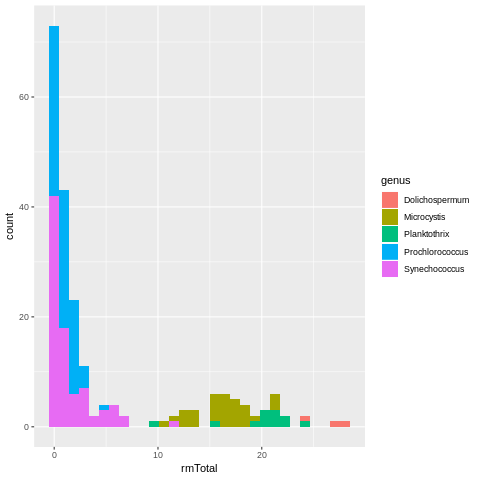

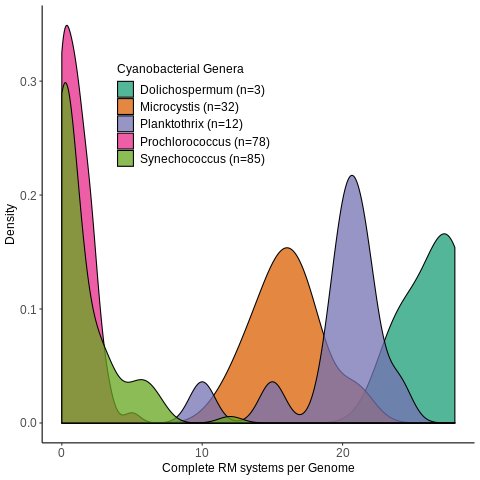

In [49]:
%%R -i df
library("ggplot2")

axis_text_size=12

A<-ggplot(df, aes(rmTotal,fill=genus)) +
  geom_histogram()
B<-ggplot(df, aes(rmTotal,fill=gen_n)) +
  geom_density(adjust = 1.5,alpha=.75)+
  theme_bw()+
  theme(panel.border = element_blank(), legend.position = c(0.35, 0.75),
        legend.text=element_text(size=axis_text_size),
        axis.title.y=element_text(size=axis_text_size),
        axis.title.x=element_text(size=axis_text_size),
        legend.title=element_text(size=axis_text_size),
        panel.grid.minor = element_blank(),panel.grid.major = element_blank(),
        axis.line = element_line(color="black"),
           axis.text=element_text(size=axis_text_size))+
  labs(x="Complete RM systems per Genome",y="Density", fill = "Cyanobacterial Genera")+
  scale_fill_brewer(palette="Dark2")
  
print(A)
print(B)

ggsave("figures/CyanoDists.png",plot=B,device="png",width=10,height=4,dpi=900)
